# Import and setup

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

/Users/kunthshah/Desktop/Crypto-Price-Moevement-Prediction/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
df = pd.read_csv('Dataset/crypto_price_movement_dataset.csv')
df.head()

,Date,Open_Price,Close_Price,High_Price,Low_Price,Price_Change,Volume,MA_5,MA_10,RSI,Volatility,Sentiment_Score,Global_Economy,Event_Impact,Price_Movement
0,2023-01-01,41236.203565,41583.440143,42164.219187,41514.228466,347.236578,6746503,0.000000,0.0,39.782970,0.011679,0.806251,1,0.052810,1
1,2023-01-02,58521.429192,58515.946236,59042.917886,57930.249488,-5.482956,6569064,0.000000,0.0,52.667760,0.042812,0.010386,0,0.082150,0
2,2023-01-03,51959.818254,51655.283865,52006.320815,50856.415124,-304.534389,8066677,0.000000,0.0,30.473258,0.031347,0.555665,1,0.092787,0
3,2023-01-04,47959.754526,48196.396313,48689.608970,47431.923218,236.641787,8759881,0.000000,0.0,54.708497,0.038986,-0.563440,0,0.079497,1
4,2023-01-05,34680.559213,34599.237349,34964.333984,33761.841141,-81.321864,7696906,46910.060781,0.0,30.916759,0.045281,0.242467,0,0.064309,0


# Exploratory Data Analysis 

## Data pre-processing

In [4]:
print(df.isnull().sum())

Date               0
Open_Price         0
Close_Price        0
High_Price         0
Low_Price          0
Price_Change       0
Volume             0
MA_5               0
MA_10              0
RSI                0
Volatility         0
Sentiment_Score    0
Global_Economy     0
Event_Impact       0
Price_Movement     0
dtype: int64


In [5]:
print(df.dtypes)

Date                object
Open_Price         float64
Close_Price        float64
High_Price         float64
Low_Price          float64
Price_Change       float64
Volume               int64
MA_5               float64
MA_10              float64
RSI                float64
Volatility         float64
Sentiment_Score    float64
Global_Economy       int64
Event_Impact       float64
Price_Movement       int64
dtype: object


In [9]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.dtypes

Date               datetime64[ns]
Open_Price                float64
Close_Price               float64
High_Price                float64
Low_Price                 float64
Price_Change              float64
Volume                      int64
MA_5                      float64
MA_10                     float64
RSI                       float64
Volatility                float64
Sentiment_Score           float64
Global_Economy              int64
Event_Impact              float64
Price_Movement              int64
dtype: object

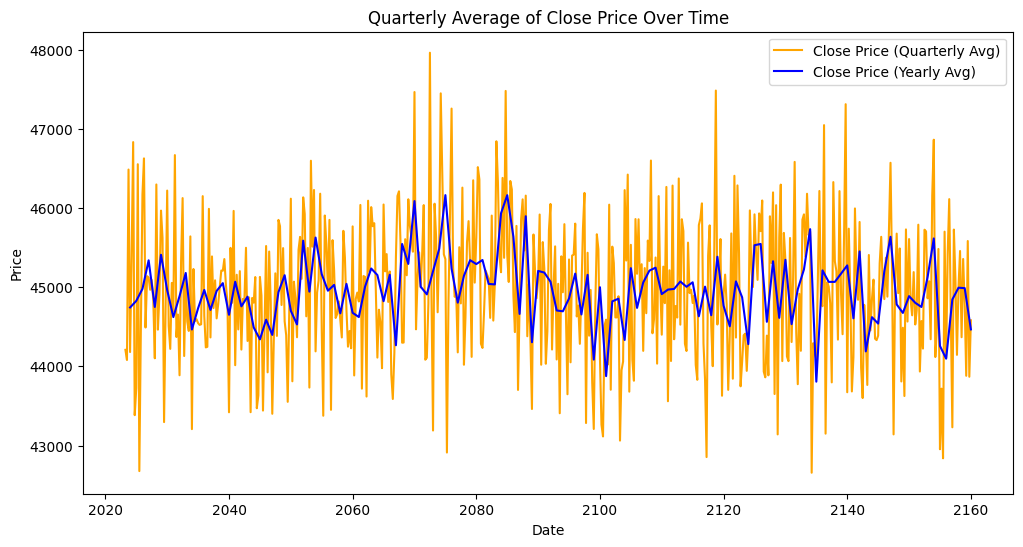

In [14]:
# Group by quarter and calculate the mean of prices
df_quarter = df.set_index('Date').resample('Q').mean().reset_index()
df_year = df.set_index('Date').resample('Y').mean().reset_index()


plt.figure(figsize=(12, 6))
plt.plot(df_quarter['Date'], df_quarter['Close_Price'], label='Close Price (Quarterly Avg)', color='orange')
plt.plot(df_year['Date'], df_year['Close_Price'], label='Close Price (Yearly Avg)', color='blue')
plt.title('Quarterly Average of Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

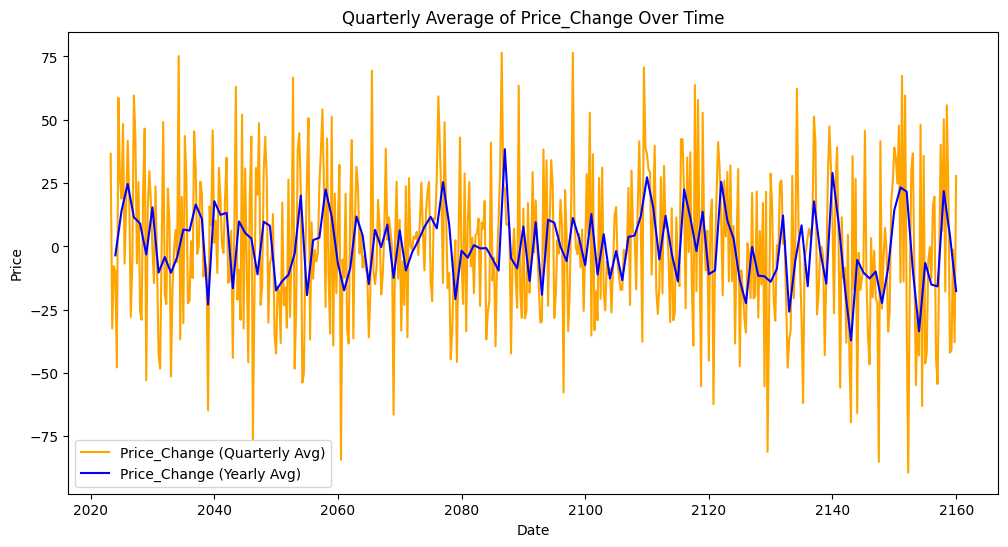

In [15]:
# Group by quarter and calculate the mean of prices
df_quarter = df.set_index('Date').resample('Q').mean().reset_index()
df_year = df.set_index('Date').resample('Y').mean().reset_index()


plt.figure(figsize=(12, 6))
plt.plot(df_quarter['Date'], df_quarter['Price_Change'], label='Price_Change (Quarterly Avg)', color='orange')
plt.plot(df_year['Date'], df_year['Price_Change'], label='Price_Change (Yearly Avg)', color='blue')
plt.title('Quarterly Average of Price_Change Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [16]:
# Calculate indices for train (70%), validation (20%), and test (10%) splits
n = len(df)
train_end = int(n * 0.7)
val_end = train_end + int(n * 0.2)

train = df.iloc[:train_end]
val = df.iloc[train_end:val_end]
test = df.iloc[val_end:]

print("Train shape:", train.shape)
print("Validation shape:", val.shape)
print("Test shape:", test.shape)

Train shape: (35000, 15)
Validation shape: (10000, 15)
Test shape: (5000, 15)


In [17]:
# Prepare training features and target
X_train = train.drop(['Date', 'Price_Movement'], axis=1)
y_train = train['Price_Movement']

# Prepare testing features and target from the validation split
X_test = val.drop(['Date', 'Price_Movement'], axis=1)
y_test = val['Price_Movement']

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (35000, 13)
y_train shape: (35000,)
X_test shape: (10000, 13)
y_test shape: (10000,)


In [19]:
from tensorflow.keras.layers import LSTM

# Reshape the data to 3D for LSTM: (samples, timesteps, features)
X_train_lstm = np.array(X_train).reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.array(X_test).reshape((X_test.shape[0], 1, X_test.shape[1]))


# Build the LSTM model for binary classification
model = Sequential()
model.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dense(1, activation='tanh'))


model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_lstm, y_train, epochs=10, batch_size=64, 
                    validation_data=(X_test_lstm, y_test))

Epoch 1/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4938 - loss: 8.1591 - val_accuracy: 0.5028 - val_loss: 8.0139
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4919 - loss: 8.1888 - val_accuracy: 0.5028 - val_loss: 8.0139
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 978us/step - accuracy: 0.4938 - loss: 8.1582 - val_accuracy: 0.5028 - val_loss: 8.0139
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 966us/step - accuracy: 0.4972 - loss: 8.1044 - val_accuracy: 0.5028 - val_loss: 8.0139
Epoch 5/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4917 - loss: 8.1931 - val_accuracy: 0.5028 - val_loss: 8.0139
Epoch 6/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 973us/step - accuracy: 0.4961 - loss: 8.1217 - val_accuracy: 0.5028 - val_loss: 8.0139
Epoch 7/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 973us/step - accuracy: 0.4977 - loss: 8.0963 - val_accuracy: 0.5028 - val_loss: 8.0139
Epoch 8/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 991us/step - accuracy: 0.4925 - loss: 8.1792 - val_ac